# 单个人多次深蹲相似度实验
* 由一个人做多个深蹲
* 设置一个标准的动作序列模板,通过DTW得相似度(即得分)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import utli
from utli import Avg_filter
import pandas as pd
import math
import os
# import importlib
# importlib.reload(utli)

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.family'] = 'Microsoft YaHei'
# %matplotlib inline


## 数据说明

* 数据是由一段连续深蹲视频通过`mediapipe`关键点检测, 测得指定的几个需要评测的关节点角度
  * 详情见`深蹲检测/文档.docx`
* 原视频在`/data/share/vedio1_copy.mp4`
* 角度计算方式通过余弦公式
* 为了方便,实验只用到了角度A,实际运用应该把需要的角度分别计算,再加权平均
  * ![](../.assets\image-20220213232646424.png)

In [13]:
# 提前使用mediapipe生成的关键关节的角度数据
data_path = r'D:\bishe\mediapipe\repCounter\data\test_20220213-221617\data.npz'
data = np.load(data_path)
print(len(data))
for i in data.keys():
    print(i)


9
time
angle_A_r
angle_A_l
angle_B_r
angle_B_l
angle_C_r
angle_C_l
angle_D_r
angle_D_l


![figure](http://tuchuang-gsegse.oss-cn-chengdu.aliyuncs.com/img/2022/02/13/b10327fbae6bdab651c3f34a84854e08-figure-0311b6.png)

In [14]:
serial_data = data['angle_A_r'] 
time = data['time']  # 时间戳
print(serial_data.shape, time.shape)


(463,) (463,)


## 使用均值滤波进行平滑



In [19]:
avg_f = Avg_filter(window_size=10)
serial_data_f = np.array([avg_f.filte(ii) for ii in serial_data])
print(len(serial_data), len(serial_data_f))


463 463


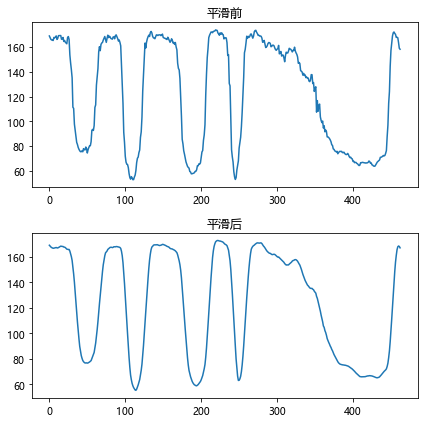

In [39]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
axes[0].plot(np.arange(len(serial_data)), serial_data)
axes[0].set_title('平滑前')
axes[1].plot(np.arange(len(serial_data_f)), serial_data_f)
axes[1].set_title('平滑后')
fig.tight_layout()


## 核心:比较两个序列的相似程度
* 本算法的核心在于利用计算两个序列的相似程度
* 使用动态时间规整(DTW)算法
* [知乎讲解](https://zhuanlan.zhihu.com/p/43247215)
* [python实现库](https://github.com/pierre-rouanet/dtw)

## 由距离计算相似度

* 采用类似[MS coco](https://cocodataset.org/#keypoints-eval)的OKS计算方式, 把两段序列的平均距离映射到(0, 1]
$$
similarity(d)=exp{(-\frac{d^2}{2\sigma^2})}
$$
* 其中sigma需要经验值计算
  + 取两段相似的序列, 另其sim>=0.9, 反向算一个$\sigma$
  + 也可以通过动态改变$\sigma$来改变动作的宽松程度, 即$\sigma$越高, 对应的分数越高, 反之亦然


In [25]:
def normal(x, mu=0, sigma=1):
    """
    由距离计算相似度
    """
    return np.exp(-np.abs(x)**2 / (2 * sigma**2))
    # p = 1 / math.sqrt(2 * math.pi * sigma**2)
    # return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)


print(normal(0), normal(1))


1.0 0.6065306597126334


In [122]:
def manhattan_distance(x, y): return np.abs(x - y)  # 曼哈顿距离
def get_sigma(x,sim=0.97):
    """根据两个相似的clip,计算其平均距离,反向计算sigma

    Args:
        x :实际平均距离 
        sim (float, optional): 两个片段的理论得分
    """
    sigma = np.sqrt(x**2 / (-2 * np.log(sim)))
    return sigma

SIGMA=get_sigma(70) #283.61

def fun(x, y, debug=True):
    # x,y=angle2rad(x),angle2rad(y)#角度转弧度
    d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=manhattan_distance)
    if debug:
        # print(d)
        # plt.cla()
        plt.close(1)
        plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
        plt.plot(path[0], path[1], 'w')
        plt.show()
    d_avg = d / len(path)  # np.sqrt(len(x)*len(y)) #算平均距离
    sim = normal(d_avg, sigma=SIGMA)  # 归一化
    return d, cost_matrix, acc_cost_matrix, path, sim,d_avg


## 以测试数据为例


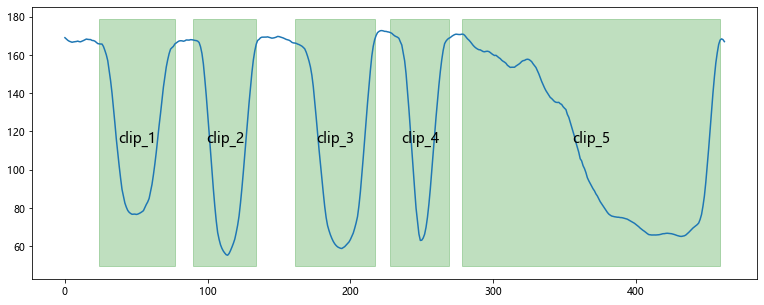

In [123]:
# 几个clip序列
clips=[]
clip_pts = [(24, 78),  # 不合格
            (90, 135),  # 正常1
            (161, 218),  # 正常2
            (228, 270),  # 快速
            (278, 460),  # 慢速
            ]
x = np.arange(len(serial_data_f))
fig, ax = plt.subplots(figsize=(13, 5))
plt.plot(x, serial_data_f)
x_in_section = np.zeros_like(x)  # bool
for idx, (x1, x2) in enumerate(clip_pts):
    x_in_section[x1:x2] = 1
    clips.append(serial_data_f[x1:x2])
    plt.text((x1 + x2) / 2, np.mean(plt.ylim()), f"clip_{idx+1}", horizontalalignment='center', fontsize=14)

plt.fill_between(x, *plt.ylim(), where=x_in_section, color='green', alpha=0.25,)  # transform=plt.get_xaxis_transform())


================= 1 1 =================


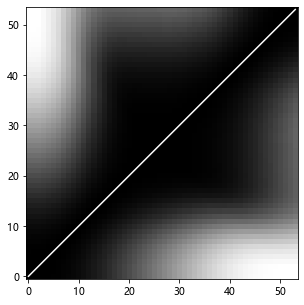

总距离	 0.0 	平均距离	 0.0 	相似度	 100.00%	
================= 1 2 =================


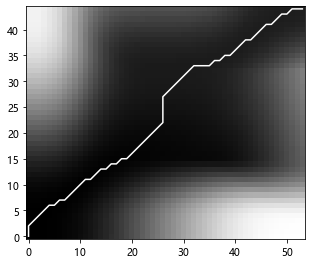

总距离	 328.9276353888397 	平均距离	 164.46381769441984 	相似度	 84.52%	
================= 1 3 =================


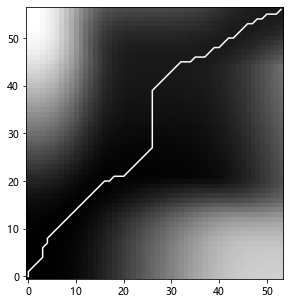

总距离	 361.6482381957937 	平均距离	 180.82411909789684 	相似度	 81.61%	
================= 1 4 =================


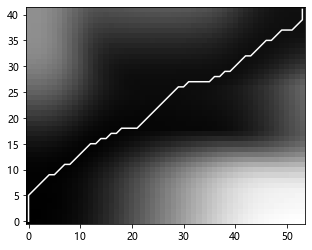

总距离	 192.76556324897248 	平均距离	 96.38278162448624 	相似度	 94.39%	
================= 1 5 =================


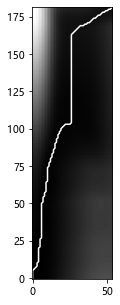

总距离	 660.8027354653394 	平均距离	 330.4013677326697 	相似度	 50.73%	
================= 2 2 =================


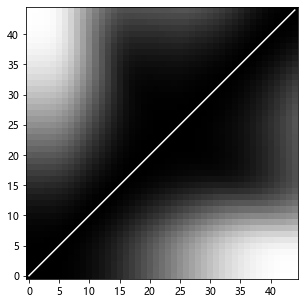

总距离	 0.0 	平均距离	 0.0 	相似度	 100.00%	
================= 2 3 =================


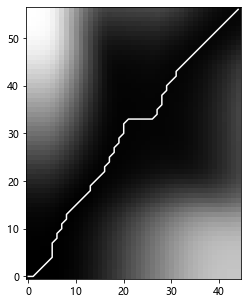

总距离	 85.87571153661138 	平均距离	 42.93785576830569 	相似度	 98.86%	
================= 2 4 =================


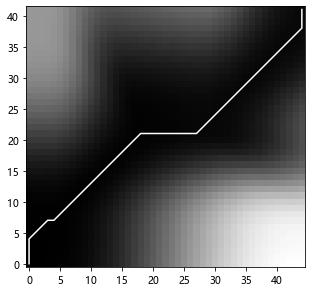

总距离	 105.04599892182169 	平均距离	 52.522999460910846 	相似度	 98.30%	
================= 2 5 =================


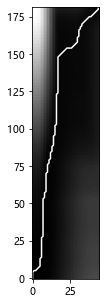

总距离	 376.8471800440411 	平均距离	 188.42359002202056 	相似度	 80.20%	
================= 3 3 =================


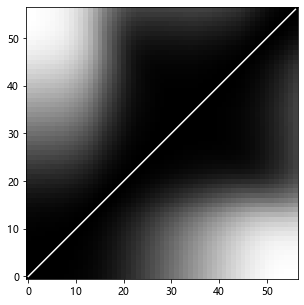

总距离	 0.0 	平均距离	 0.0 	相似度	 100.00%	
================= 3 4 =================


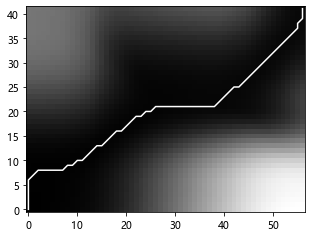

总距离	 128.58642115584547 	平均距离	 64.29321057792274 	相似度	 97.46%	
================= 3 5 =================


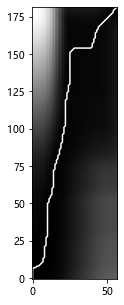

总距离	 289.84944583885795 	平均距离	 144.92472291942897 	相似度	 87.76%	
================= 4 4 =================


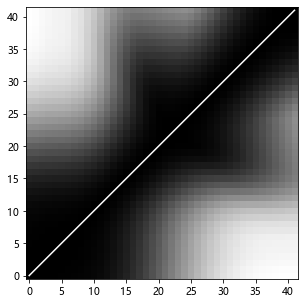

总距离	 0.0 	平均距离	 0.0 	相似度	 100.00%	
================= 4 5 =================


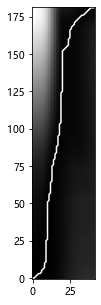

总距离	 300.82965556335 	平均距离	 150.414827781675 	相似度	 86.88%	
================= 5 5 =================


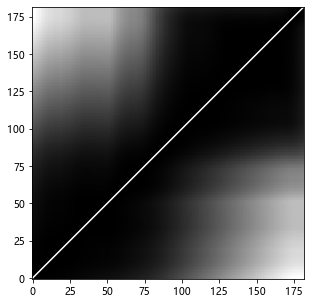

总距离	 0.0 	平均距离	 0.0 	相似度	 100.00%	


In [124]:
plt.rcParams['figure.figsize'] = [5, 5]
# 滤波后的结果
for i in range(0, 5):
    for j in range(i, 5):
        print("=======================================")
        print("=================", i+1, j+1, "=================")
        d_sum, _, _, _, sim, d_avg = fun(clips[i], clips[j])
        print("总距离\t", d_sum,"\t平均距离\t", d_avg, '\t相似度\t', "{:.2f}%\t".format(sim * 100))


## 打分
* 我们假设`clip2`是**标准模板**,可以以此将所有的clips和标准模板计算相似度,作为最终的评分
  * 实际中的标准模板应该是一个固定的,人为指定的
  * 但是用一个模板可能会导致过于苛刻,可以尝试多个标准模板,采用KNN进行平均
* 将所有clip的相似度进行平均得到最后的总分


In [127]:
standard_template=clips[2].copy()
scores=[]
for clip in  clips:
    scores.append(fun(clip,standard_template,debug=False)[4])

In [129]:
df = pd.DataFrame(map(lambda x: '{:.2f}'.format(100 * x), scores), columns=['得分(相似度)'], index=[f'clip{i+1}' for i in range(len(scores))])
df


,得分(相似度)
clip1,81.61
clip2,98.86
clip3,100.00
clip4,97.46
clip5,87.76


In [130]:
print("最终得分 {:.2f}".format(100*np.mean(scores)))

最终得分 93.14


## TODO

* ~~TODO 滤波平滑~~
* ~~TODO 用户提供模板, 根据动作的平均距离达0.97反向算sigma~~

* TODO 换成kalman filter
* TODO 动作分类
    * 自动判断是哪一个运动项目
* ~~TODO 多视角相机, 时间戳对齐测试~~
* TODO FFT得到周期信息
* TODO 使用DTW的升级算法
* TODO gif上加入骨骼进行展示
  * 写一个py脚本生成一个带关键点的同步的mp4
* TODO 自动获取clip的区间
  * 在计数的基础上,要去除一部分的端点
    * 比如在深蹲起来站立的时候站立一段时间,曲线是直线,可以算$\Delta{\theta}$
* TODO 多人计算
  * 和单人大同小异

## Reference

@article{Chen_Yang_2020, title={Pose Trainer: Correcting Exercise Posture using Pose Estimation}, url={http://arxiv.org/abs/2006.11718}, abstractNote={Fitness exercises are very beneficial to personal health and fitness; however, they can also be ineffective and potentially dangerous if performed incorrectly by the user. Exercise mistakes are made when the user does not use the proper form, or pose. In our work, we introduce Pose Trainer, an application that detects the user’s exercise pose and provides personalized, detailed recommendations on how the user can improve their form. Pose Trainer uses the state of the art in pose estimation to detect a user’s pose, then evaluates the vector geometry of the pose through an exercise to provide useful feedback. We record a dataset of over 100 exercise videos of correct and incorrect form, based on personal training guidelines, and build geometric-heuristic and machine learning algorithms for evaluation. Pose Trainer works on four common exercises and supports any Windows or Linux computer with a GPU.}, note={arXiv: 2006.11718}, journal={arXiv:2006.11718 [cs]}, author={Chen, Steven and Yang, Richard R.}, year={2020}, month={Jun} }
